# ELI5 Dataset - Gemini Answer Generation

This notebook processes the ELI5 (Explain Like I'm 5) dataset and generates answers using Google's Gemini.

## Dataset Information
- **Source**: HuggingFace dataset `rexarski/eli5_category`
- **Period**: January 2017 - June 2021
- **Content**: Human-written questions and answers from the ELI5 subreddit
- **Purpose**: Expand dataset with Gemini-generated answers for comparison and analysis

####  **<span style="color:red">IMPORTANT: <span>**
1. Finalize how what columns to pick for the final dataset
    * Current: drop score & subreddit column ONLY
2. Finalize what models to use
    * Current: Gemini 2.5 flash
3. The current gemini df generation only saves the successful attempts to df_gemini (i.e. sample size = 10, but 2 fail, final df length is 8)

## 1. Install and Import Required Libraries

In [23]:
# Install required packages (run once)
!pip install pandas numpy datasets
!pip install google-generativeai
!pip install gdown matplotlib seaborn tqdm
!pip install fastparquet

   ---------------------------------------- 0.0/667.6 kB ? eta -:--:--
   --------------- ------------------------ 262.1/667.6 kB ? eta -:--:--
   ---------------------------------------- 667.6/667.6 kB 4.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 1.7/1.7 MB 9.3 MB/s eta 0:00:00


In [5]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
import json
import os
from datetime import datetime
import textwrap

# Gemini API
import google.generativeai as genai

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

C:\Users\paolo\AppData\Local\Temp\ipykernel_19448\2939530607.py:14: FutureWarning: 

All support for the `google.generativeai` package has ended. It will no longer be receiving 
updates or bug fixes. Please switch to the `google.genai` package as soon as possible.
See README for more details:

https://github.com/google-gemini/deprecated-generative-ai-python/blob/main/README.md

  import google.generativeai as genai


## 2. Set Up Gemini API Key

In [6]:
import dotenv
dotenv.load_dotenv()
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")

if GEMINI_API_KEY:
    genai.configure(api_key=GEMINI_API_KEY)
    print("Gemini API key configured successfully")
else:
    print("Warning: Gemini API key not set")

Gemini API key configured successfully


In [7]:
# List available Gemini models
print("Available Gemini models:")
print("=" * 80)

for model in genai.list_models():
    if 'generateContent' in model.supported_generation_methods:
        print(f"Model: {model.name}")
        print(f"  Display Name: {model.display_name}")
        print(f"  Description: {model.description}")
        print(f"  Supported Methods: {model.supported_generation_methods}")
        print("-" * 80)

Available Gemini models:
Model: models/gemini-2.5-flash
  Display Name: Gemini 2.5 Flash
  Description: Stable version of Gemini 2.5 Flash, our mid-size multimodal model that supports up to 1 million tokens, released in June of 2025.
  Supported Methods: ['generateContent', 'countTokens', 'createCachedContent', 'batchGenerateContent']
--------------------------------------------------------------------------------
Model: models/gemini-2.5-pro
  Display Name: Gemini 2.5 Pro
  Description: Stable release (June 17th, 2025) of Gemini 2.5 Pro
  Supported Methods: ['generateContent', 'countTokens', 'createCachedContent', 'batchGenerateContent']
--------------------------------------------------------------------------------
Model: models/gemini-2.0-flash
  Display Name: Gemini 2.0 Flash
  Description: Gemini 2.0 Flash
  Supported Methods: ['generateContent', 'countTokens', 'createCachedContent', 'batchGenerateContent']
-------------------------------------------------------------------------

## 3. Load the ELI5 Dataset

####  **<span style="color:red">IMPORTANT: <span>**
You must run the scripts in the human_data folder to get the ELI5 Dataset

In [8]:
path="./human_data/output/eli5_combined.csv"

df = pd.read_csv(path)
print(f"Dataset loaded with {len(df)} records")
df.head()

Dataset loaded with 261214 records


,q_id,title,category,subreddit,a_id,text,score
0,5lchat,Why there was a 'leap second' added to the end of 2016?,Other,explainlikeimfive,dbuoyxl,"the rotation of the earth is not a constant. in fact the rotation of the earth is slowing down, which means that a full day is getting slightly longer. without leap seconds our clocks would slowly drift ever so slightly out of sync with the actual day. we could deal with this by redefining how how long 1 second is, making it slightly longer so that one day is still exactly 24*60*60 seconds. but in practice that is really inconvenient for a lot of our technology which relies on very precise timing. its easier to just move us ahead one second every couple of years or so.",44
1,5lchat,Why there was a 'leap second' added to the end of 2016?,Other,explainlikeimfive,dbur7gi,"The Earth's rotation is not regular. It varies a bit, so sometimes we add a second. We do this to ensure that noon is always going to be sometime around mid-day. If we did not add leap seconds, over a very long period of time where the Earth's rotation slowly changed, noon could end up being at dusk. We want to keep 7am in the morning, noon at mid-day, 7pm around evening, etc. Though we have never had one, it's also possible to have a negative leap second. That is, taking away a second from the year. This has never happened, but if the Earth's rotation were to speed up, it could happen. The biggest thing to know about leap seconds is that they can cause computer problems. You might remember the Y2K bug. A leap second can cause similar problems, and they actually have caused problems in the past. The reason for this is that generally we expect a day to have 24 hours, and for time to always move forward. With a leap second this is not true. When writing software, programers try to think of all the possible exceptions that could happen withing their code. For example, the program might expect a word, but instead get a number. A good programmer will check for these exceptions and deal with them. However, a programer can easily forget about leap seconds and not have a fail-safe in their code for when a day have more than 24 hours. When such an exception happens, the program can produce errors or crash. It is an interesting topic, you can read more about it here: URL_0",5
2,5lchat,Why there was a 'leap second' added to the end of 2016?,Other,explainlikeimfive,dbuotht,"Because the Earth's rotation is slowing. If you multiply 24 hours by 60 minutes by 60 seconds, you find that there are 86400 seconds per day. The problem is that our definition of the second is based on [an average that is a century old.]( URL_0 ) In modern times, the average day is about 2 thousandths of a second longer—again, because of Earth's slowing rotation. Those thousandths of a second add up, so every few years we have to slip in an extra second to account for them. Without leap seconds, we'd eventually end up with noon at 7 o'clock, though admittedly, this would take a very long time.",4
3,5lcjq6,How do you claim undiscovered land?,Other,explainlikeimfive,dbuplm8,"Imagine you are out walking in the woods near your house and you find a cave. You think to yourself, ""Gee that's a real nice cave, there's just enough room for my rocket car, my crime fighting computer and my superhero costume collection. It'd be perfect for me."" Let's say that nobody already owns the cave, so you move in and bring in all your stuff. You carve a costume wardrobe into one of the stone walls, grab a shovel and flatten the floor a bit so your rocket car can drive in and out. After you've finished working on the cave and fixing it up you start to think of it as yours. But not everybody agrees. There's another guy a few miles away who also fancies himself a billionaire superhero like you. Flies around in a stupid metal suit that he made himself while a prisoner of the Taliban or something like that. Anyway, one day he walks by and sees your cave and thinks, ""That's a great cave

## 4. Explore Dataset Structure

In [9]:
# Display basic information
print("=" * 80)
print("DATASET INFORMATION")
print("=" * 80)
df.info()
print("\n" + "=" * 80)
print("FIRST FEW ROWS")
print("=" * 80)
df.head()

DATASET INFORMATION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261214 entries, 0 to 261213
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   q_id       261214 non-null  object
 1   title      261214 non-null  object
 2   category   261214 non-null  object
 3   subreddit  261214 non-null  object
 4   a_id       261214 non-null  object
 5   text       261214 non-null  object
 6   score      261214 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 14.0+ MB

FIRST FEW ROWS


,q_id,title,category,subreddit,a_id,text,score
0,5lchat,Why there was a 'leap second' added to the end of 2016?,Other,explainlikeimfive,dbuoyxl,"the rotation of the earth is not a constant. in fact the rotation of the earth is slowing down, which means that a full day is getting slightly longer. without leap seconds our clocks would slowly drift ever so slightly out of sync with the actual day. we could deal with this by redefining how how long 1 second is, making it slightly longer so that one day is still exactly 24*60*60 seconds. but in practice that is really inconvenient for a lot of our technology which relies on very precise timing. its easier to just move us ahead one second every couple of years or so.",44
1,5lchat,Why there was a 'leap second' added to the end of 2016?,Other,explainlikeimfive,dbur7gi,"The Earth's rotation is not regular. It varies a bit, so sometimes we add a second. We do this to ensure that noon is always going to be sometime around mid-day. If we did not add leap seconds, over a very long period of time where the Earth's rotation slowly changed, noon could end up being at dusk. We want to keep 7am in the morning, noon at mid-day, 7pm around evening, etc. Though we have never had one, it's also possible to have a negative leap second. That is, taking away a second from the year. This has never happened, but if the Earth's rotation were to speed up, it could happen. The biggest thing to know about leap seconds is that they can cause computer problems. You might remember the Y2K bug. A leap second can cause similar problems, and they actually have caused problems in the past. The reason for this is that generally we expect a day to have 24 hours, and for time to always move forward. With a leap second this is not true. When writing software, programers try to think of all the possible exceptions that could happen withing their code. For example, the program might expect a word, but instead get a number. A good programmer will check for these exceptions and deal with them. However, a programer can easily forget about leap seconds and not have a fail-safe in their code for when a day have more than 24 hours. When such an exception happens, the program can produce errors or crash. It is an interesting topic, you can read more about it here: URL_0",5
2,5lchat,Why there was a 'leap second' added to the end of 2016?,Other,explainlikeimfive,dbuotht,"Because the Earth's rotation is slowing. If you multiply 24 hours by 60 minutes by 60 seconds, you find that there are 86400 seconds per day. The problem is that our definition of the second is based on [an average that is a century old.]( URL_0 ) In modern times, the average day is about 2 thousandths of a second longer—again, because of Earth's slowing rotation. Those thousandths of a second add up, so every few years we have to slip in an extra second to account for them. Without leap seconds, we'd eventually end up with noon at 7 o'clock, though admittedly, this would take a very long time.",4
3,5lcjq6,How do you claim undiscovered land?,Other,explainlikeimfive,dbuplm8,"Imagine you are out walking in the woods near your house and you find a cave. You think to yourself, ""Gee that's a real nice cave, there's just enough room for my rocket car, my crime fighting computer and my superhero costume collection. It'd be perfect for me."" Let's say that nobody already owns the cave, so you move in and bring in all your stuff. You carve a costume wardrobe into one of the stone walls, grab a shovel and flatten the floor a bit so your rocket car can drive in and out. After you've finished working on the cave and fixing it up you start to think of it as yours. But not everybody agrees. There's another guy a few miles away who also fancies himself a billionaire superhero like you. Flies around in a stupid metal suit that he made himself while a prisoner of the Taliban or something like that. Anyway, one day he walks by and sees your cave and thinks, ""That's a great cave

In [10]:
# Statistical summary
print("=" * 80)
print("STATISTICAL SUMMARY")
print("=" * 80)
df.describe(include='all')

STATISTICAL SUMMARY


,q_id,title,category,subreddit,a_id,text,score
count,261214,261214,261214,261214,261214,261214,261214.000000
unique,105004,104336,12,1,261214,261160,NaN
top,l7ckr5,Stock Market Megathread,Biology,explainlikeimfive,dbuoyxl,"Great read here. I experienced a very traumatic incident almost two years ago and have felt emotionally numb and have had a weak nervous system ( feel stinging sensations in my body and numbness in my fingers sometimes) I am just wondering if anyone has any therapeutic methods or ways to improve my overal wellbeing and returning to my previous well-being that I really want to feel again. Any reply would help. I've heard meditation, essential oils and exercise in general will help. Sadly, I haven't taken time to do any of those and have therefore not improved how I feel, yet I've been very discontent with how I feel",NaN
freq,489,489,77811,261214,1,2,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,94.506604
std,NaN,NaN,NaN,NaN,NaN,NaN,806.428891
min,NaN,NaN,NaN,NaN,NaN,NaN,3.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,4.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,6.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,14.000000


In [11]:
# Check for missing values
print("=" * 80)
print("MISSING VALUES")
print("=" * 80)
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_pct
})
print(missing_df[missing_df['Missing Count'] > 0])

MISSING VALUES
Empty DataFrame
Columns: [Missing Count, Percentage]
Index: []


## 5. Data Cleaning and Filtering

In [12]:
df_clean = df.copy()

print(f"Original dataset size: {len(df_clean)} rows")

# 1. Remove duplicates
df_clean = df_clean.drop_duplicates()
print(f"After removing duplicates: {len(df_clean)} rows")

# 2. Filter by text length (keep only answers with <= 1000 characters)
# Justification: Mean is approx. 600 and Median is approx. 400. 
# Highest is around 9000 and token limit is 1000
df_clean = df_clean[df_clean['text'].str.len() <= 1000]
print(f"After filtering text length: {len(df_clean)} rows")

# 3. Drop unnecessary columns (score && subreddit)
df_clean = df_clean.drop(columns=['score', 'subreddit'], errors='ignore')

print(f"\nFinal cleaned dataset size: {len(df_clean)} rows")
print(f"Removed: {len(df) - len(df_clean)} rows ({((len(df) - len(df_clean)) / len(df) * 100):.2f}%)")

Original dataset size: 261214 rows
After removing duplicates: 261214 rows
After filtering text length: 220258 rows

Final cleaned dataset size: 220258 rows
Removed: 40956 rows (15.68%)


## 6. Load questions to an array

In [13]:
questions = df_clean['title'].tolist()

print("Question num: "  + str(len(questions)))

Question num: 220258


## 7. Generate Answers with Gemini

In [14]:
sample_size = 2

In [15]:
def generate_gemini_answer(question, model="gemini-2.5-flash", max_retries=3):
    """
    Generate an ELI5-style answer using Gemini.
    
    Args:
        question: The question to answer
        model: Gemini model to use (default: gemini-2.5-flash)
        max_retries: Number of retry attempts on failure
    
    Returns:
        Generated answer as string, or None if failed
    """
    if not GEMINI_API_KEY:
        return "ERROR: Gemini API key not configured"
    
    prompt = f"""You are answering questions in the style of the ELI5 (Explain Like I'm 5) subreddit. 
Provide a clear, simple explanation that a 5-year-old could understand, but still be informative.
Keep everything as one block of text.

Question: {question}

Answer:"""
    
    for attempt in range(max_retries):
        try:
            model_instance = genai.GenerativeModel(model)
            response = model_instance.generate_content(
                prompt,
                generation_config=genai.types.GenerationConfig(
                    temperature=0.7,
                    max_output_tokens=1000,
                )
            )
            return response.text.strip()
        
        except Exception as e:
            print(f"Attempt {attempt + 1} failed: {str(e)}")
            if attempt < max_retries - 1:
                time.sleep(2 ** attempt)
            else:
                return f"ERROR: {str(e)}"
    
    return None

# Test the function
print("TEST")
test_question = "Why is the sky blue?"
test_answer = generate_gemini_answer(test_question)
print(f"\nQuestion: {test_question}")
print(f"Answer: {test_answer}")

TEST

Question: Why is the sky blue?
Answer: Imagine sunlight is like a big mix of all your favorite crayon colors – red, orange, yellow, green, blue, purple – all squished together! When it travels from the sun to us, it hits tiny, tiny invisible pieces of air in the sky, like super tiny bouncy balls. Blue light is like a very bouncy ball, and it bounces off these tiny pieces *way* more easily and in all directions than the other colors. So, blue light goes boing, boing, boing everywhere in the sky, scattering all around! Because there's so much blue light bouncing all over the place, it makes the whole sky look like a giant blue blanket above us. The other colors just keep going mostly straight, but the blue ones are having a big bounce party in the sky!


In [16]:
# Generate Gemini answers for the dataset

def batch_generate_gemini(df, questions, sample_size=None, delay=1):
    # Determine which indices to process
    if sample_size is None:
        target_count = len(questions)
    else:
        target_count = sample_size
    
    successful_rows = []
    successful_indices = []  # Track which rows succeeded
    idx = 0
    
    # Keep generating until we have enough successful answers
    with tqdm(total=target_count, desc="Generating Gemini answers") as pbar:
        while len(successful_rows) < target_count and idx < len(questions):
            question = questions[idx]
            answer = generate_gemini_answer(question)
            
            # Only include if answer doesn't start with ERROR
            if not answer.startswith("ERROR"):
                row = df.iloc[idx].copy()
                row['text'] = answer
                successful_rows.append(row)
                successful_indices.append(idx)
                pbar.update(1)
            else:
                print(f"\nSkipping row {idx} due to error")
            
            idx += 1
            time.sleep(delay)
    
    # Convert list of rows to DataFrame
    df_gemini = pd.DataFrame(successful_rows).reset_index(drop=True)
    
    print(f"\nSuccessfully generated {len(df_gemini)} answers")
    if idx >= len(questions) and len(df_gemini) < target_count:
        print(f"Warning: Only got {len(df_gemini)} successful answers out of {target_count} requested")
    
    return df_gemini, successful_indices

# CHANGE SMAP
df_gemini, gemini_indices = batch_generate_gemini(df_clean, questions, sample_size, delay=30)

Generating Gemini answers: 100%|██████████| 2/2 [01:09<00:00, 34.92s/it]


Successfully generated 2 answers


In [17]:
df_gemini.iloc[0]

q_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            5lchat
title                                                                                                                                                                                            

## 7. Compare Human vs Gemini Answers

In [18]:
# Calculate answer lengths for both human and Gemini datasets
def calculate_answer_stats(df_human, df_gemini):
    """Calculate statistics for human and Gemini-generated answers."""
    
    stats = {}
    
    # Human stats (from df_clean)
    if 'text' in df_human.columns:
        human_lengths = df_human['text'].astype(str).str.len()
        stats['human'] = {
            'mean_length': human_lengths.mean(),
            'median_length': human_lengths.median(),
            'max_length': human_lengths.max(),
            'min_length': human_lengths.min()
        }
    
    # Gemini stats (from df_gemini)
    if 'text' in df_gemini.columns:
        gemini_lengths = df_gemini['text'].astype(str).str.len()
        stats['gemini'] = {
            'mean_length': gemini_lengths.mean(),
            'median_length': gemini_lengths.median(),
            'max_length': gemini_lengths.max(),
            'min_length': gemini_lengths.min()
        }
    
    return stats

# Calculate stats
stats = calculate_answer_stats(df_clean, df_gemini)

# Display stats
print("=" * 80)
print("ANSWER LENGTH STATISTICS")
print("=" * 80)
for source, metrics in stats.items():
    print(f"\n{source.upper()}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.2f}")

ANSWER LENGTH STATISTICS

HUMAN:
  mean_length: 403.41
  median_length: 351.00
  max_length: 1000.00
  min_length: 28.00

GEMINI:
  mean_length: 740.50
  median_length: 740.50
  max_length: 794.00
  min_length: 687.00


C:\Users\paolo\AppData\Local\Temp\ipykernel_19448\1786601132.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot(lengths, labels=sources)


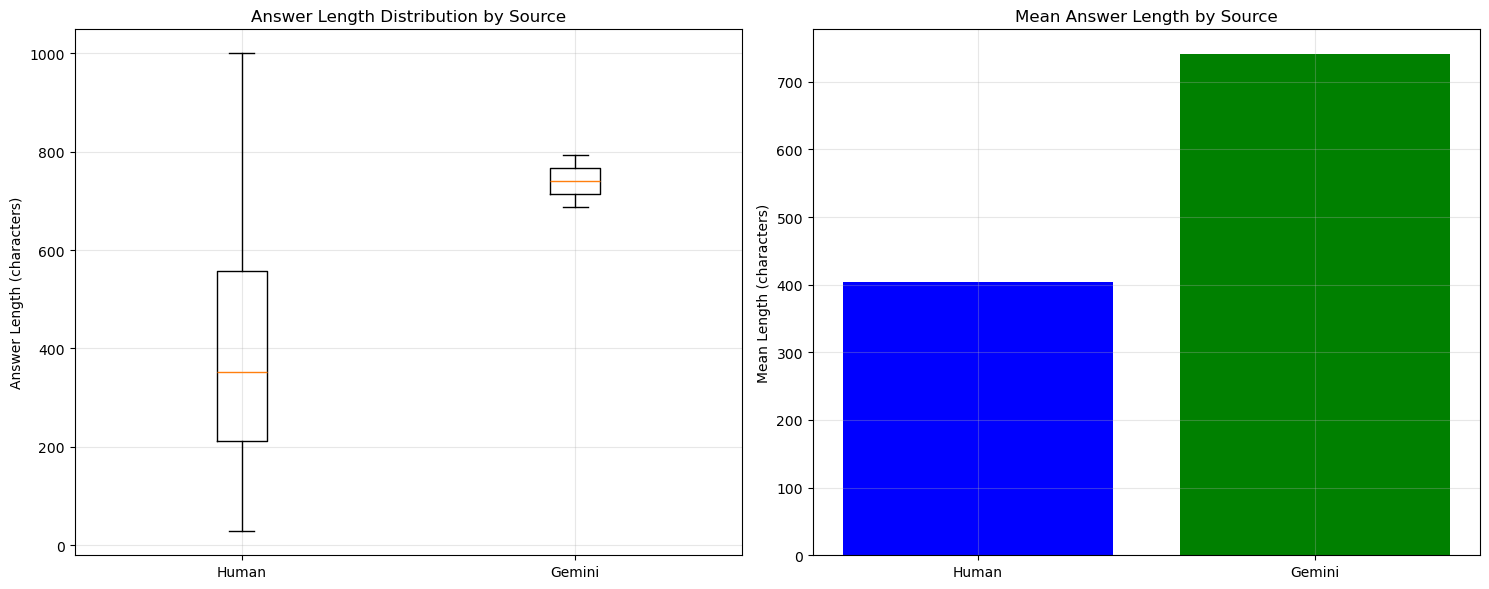

In [19]:
# Visualize answer length comparison

def plot_answer_length_comparison(df_human, df_gemini):
    """Create visualization comparing answer lengths across different sources."""
    
    # Prepare data for plotting
    plot_data = []
    
    if 'text' in df_human.columns:
        plot_data.append({
            'source': 'Human',
            'lengths': df_human['text'].astype(str).str.len().tolist()
        })
    
    if 'text' in df_gemini.columns:
        plot_data.append({
            'source': 'Gemini',
            'lengths': df_gemini['text'].astype(str).str.len().tolist()
        })
    
    if not plot_data:
        print("No data available for plotting yet.")
        return
    
    # Create box plot
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Box plot
    sources = [d['source'] for d in plot_data]
    lengths = [d['lengths'] for d in plot_data]
    
    axes[0].boxplot(lengths, labels=sources)
    axes[0].set_title('Answer Length Distribution by Source')
    axes[0].set_ylabel('Answer Length (characters)')
    axes[0].grid(True, alpha=0.3)
    
    # Bar chart of mean lengths
    mean_lengths = [np.mean(d['lengths']) for d in plot_data]
    axes[1].bar(sources, mean_lengths, color=['blue', 'green'][:len(sources)])
    axes[1].set_title('Mean Answer Length by Source')
    axes[1].set_ylabel('Mean Length (characters)')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Create visualization
plot_answer_length_comparison(df_clean, df_gemini)

In [20]:
# Sample comparison - View actual answers side by side
def compare_answers(df_human, df_gemini, index=0, width=100):
    """Display a side-by-side comparison of answers for a specific question."""
    
    row_human = df_human.iloc[index]
    row_gemini = df_gemini.iloc[index]
    
    print(f"QUESTION: {row_human['title']}")
    print()
    
    print("-" * width)
    print("HUMAN ANSWER")
    print("-" * width)
    wrapped_text = textwrap.fill(str(row_human['text']), width=width)
    print(wrapped_text)
    print()
    
    print("-" * width)
    print("GEMINI ANSWER")
    print("-" * width)
    wrapped_answer = textwrap.fill(str(row_gemini['text']), width=width)
    print(wrapped_answer)
    print()

# Compare first answer
compare_answers(df_clean, df_gemini, index=0)

QUESTION: Why there was a 'leap second' added to the end of 2016?

----------------------------------------------------------------------------------------------------
HUMAN ANSWER
----------------------------------------------------------------------------------------------------
the rotation of the earth is not a constant. in fact the rotation of the earth is slowing down,
which means that a full day is getting slightly longer. without leap seconds our clocks would slowly
drift ever so slightly out of sync with the actual day. we could deal with this by redefining how
how long 1 second is, making it slightly longer so that one day is still exactly 24*60*60 seconds.
but in practice that is really inconvenient for a lot of our technology which relies on very precise
timing. its easier to just move us ahead one second every couple of years or so.

----------------------------------------------------------------------------------------------------
GEMINI ANSWER
--------------------------

## 8. Save Enhanced Dataset

In [25]:
# Save the enhanced dataset with ALL human and Gemini answers combined and shuffled

# Prepare human answers dataset
df_human_labeled = df_clean.copy()
df_human_labeled['answer_source'] = 'human'

# Prepare Gemini answers dataset
df_gemini_labeled = df_gemini.copy()
df_gemini_labeled['answer_source'] = 'gemini'

# Combine ALL answers (human + Gemini)
df_combined = pd.concat([df_human_labeled, df_gemini_labeled], ignore_index=True)

# Shuffle the combined dataset
np.random.seed(42)  # Set seed for reproducibility
df_combined = df_combined.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Combined dataset created:")
print(f"  Total rows: {len(df_combined)}")
print(f"  Human answers: {(df_combined['answer_source'] == 'human').sum()} ({(df_combined['answer_source'] == 'human').sum()/len(df_combined)*100:.1f}%)")
print(f"  Gemini answers: {(df_combined['answer_source'] == 'gemini').sum()} ({(df_combined['answer_source'] == 'gemini').sum()/len(df_combined)*100:.1f}%)")
print(f"  Columns: {list(df_combined.columns)}")
print()

# Create output folder if it doesn't exist
output_folder = "gemini-output"
os.makedirs(output_folder, exist_ok=True)

# Generate filename with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_filename = os.path.join(output_folder, f"eli5_combined_{timestamp}.csv")

# Save to CSV
df_combined.to_csv(output_filename, index=False)
print(f"Combined dataset saved to: {output_filename}")

# Optional: Save as parquet for better compression and faster loading
parquet_filename = os.path.join(output_folder, f"eli5_combined_{timestamp}.parquet")
df_combined.to_parquet(parquet_filename, index=False)
print(f"Combined dataset saved to: {parquet_filename}")

# Save summary statistics
summary_filename = os.path.join(output_folder, f"eli5_summary_{timestamp}.json")
summary = {
    'total_rows': len(df_combined),
    'columns': list(df_combined.columns),
    'human_answers': int((df_combined['answer_source'] == 'human').sum()),
    'gemini_answers': int((df_combined['answer_source'] == 'gemini').sum()),
    'timestamp': timestamp
}

with open(summary_filename, 'w') as f:
    json.dump(summary, f, indent=2)

print(f"Summary statistics saved to: {summary_filename}")
print("\n" + "=" * 80)
print("DATASET COMBINATION COMPLETE!")
print("=" * 80)

Combined dataset created:
  Total rows: 220260
  Human answers: 220258 (100.0%)
  Gemini answers: 2 (0.0%)
  Columns: ['q_id', 'title', 'category', 'a_id', 'text', 'answer_source']

Combined dataset saved to: gemini-output\eli5_combined_20260202_181232.csv
Combined dataset saved to: gemini-output\eli5_combined_20260202_181232.parquet
Summary statistics saved to: gemini-output\eli5_summary_20260202_181232.json

DATASET COMBINATION COMPLETE!
